In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import phate
import scprep

(1000, 10)


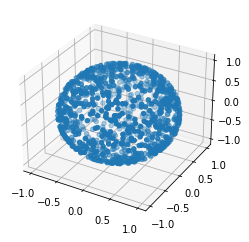

In [5]:

#Generate sphere

sphere = []
for i in range(1000):
    x = np.random.normal(0,1,3)
    sphere.append(x/(np.sqrt(np.sum(x**2))))
   
nsphere = np.array(sphere)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(nsphere[:,0], nsphere[:,1], nsphere[:,2])

zerovec = np.zeros((1000,7))

highdsphere = np.concatenate((nsphere,zerovec),axis=1)
print(highdsphere.shape)



In [6]:
#rotate sphere to higher dimensions

#print(phate_sphere)
#X = torch.tensor(highdsphere, requires_grad=True)

# export
def rotation_transform(
    X : np.ndarray, # The input matrix, of size n x d (d is # dimensions)
    tilt_angles # a list of d-1 values in [0,2pi] specifying how much to tilt in d-1 the xy, yz (...) planes
):
    # Tilt matrix into arbitrary dimensions
    d = X.shape[1]
    assert len(tilt_angles) == d - 1
    # construct Tilting Matrices TM!
    tilting_matrices_tm = []
    for i in range(d-1):
        A = np.eye(d)
        A[i][i] = np.cos(tilt_angles[i])
        A[i+1][i+1] = np.cos(tilt_angles[i])
        A[i][i+1] = np.sin(tilt_angles[i])
        A[i+1][i] = - np.sin(tilt_angles[i])
        tilting_matrices_tm.append(A)
    X_tilted = X
    for tilter in tilting_matrices_tm:
        # print(X_tilted)
        X_tilted = X_tilted @ tilter
    return X_tilted, tilting_matrices_tm


angles = list(np.repeat(90,highdsphere.shape[1]-1))
rotatesphere, nothing = rotation_transform(highdsphere, angles)



In [7]:
print(highdsphere[0,:]) #10-d hypersphere
print(rotatesphere[0,:]) #after rotation

#run phate on rotated sphere
phate_operator = phate.PHATE(random_state=42)
phate_sphere_rot = phate_operator.fit_transform(rotatesphere)

[ 0.96211979 -0.09642569 -0.25500511  0.          0.          0.
  0.          0.          0.          0.        ]
[-0.34489625 -0.17678807 -0.41305305 -0.36926805 -0.3301244  -0.29513012
 -0.26384534 -0.23587685 -0.21087312  0.42073413]
Calculating PHATE...
  Running PHATE on 1000 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.01 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.02 seconds.
  Calculating optimal t...
    Automatically selected t = 26
  Calculated optimal t in 0.20 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.08 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.79 seconds.
Calculated PHATE in 1.11 seconds.


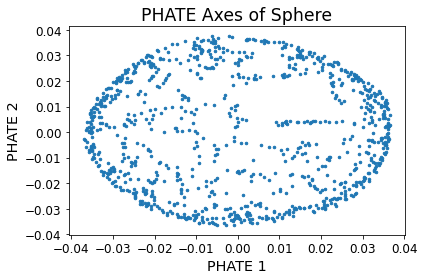

In [8]:

#PHATE Visualization of rotated sphere
cax = scprep.plot.scatter2d(phate_sphere_rot,title="PHATE Axes of Sphere",
    xlabel="PHATE 1",
    ylabel="PHATE 2",)


In [9]:

#Define data and random indices
X = torch.tensor(rotatesphere,requires_grad = True)
n = X.shape[0]
random_indices = np.random.randint(n, size=n)


In [10]:
#Define Phate function



def torch_phate(X, kernel="gaussian", bandwidth=1000, t=10):
    dists = torch.norm(X[:, None] - X, dim=2, p="fro")

    def gaussian_kernel(x):
        return torch.exp(-(dists**2) / bandwidth)

    kernel = gaussian_kernel(dists)
    p = kernel / kernel.sum(axis=0)[:, None]
    pt = torch.matrix_power(p, t)
    log_p = torch.log(pt)
    return pt


In [11]:
#Define Autoencoder class

import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(
        self,
        encoder_layer=[10, 10, 10],
        decoder_layer=[10, 10, 10],
        activation="ReLU",
        use_cuda=False,
    ) -> None:
        super().__init__()
        device = "cuda" if use_cuda else "cpu"
        
        c = 0
        encoder = []
        for i0, i1 in zip(encoder_layer, encoder_layer[1:]):
            c = c + 1
            encoder.append(nn.Linear(i0, i1))
            if c == 1:
                encoder.append(getattr(nn, "ReLU")())
            #else:
            #    encoder.append(getattr(nn, "ReLU")())
        print("Encoder",encoder)
        self.encoder = nn.Sequential(*encoder).to(device)
        
        c = 0
        decoder=[]
        for i0,i1 in zip(decoder_layer,decoder_layer[1:]):
            c = c + 1
            decoder.append(nn.Linear(i0, i1))
            if c == 1:
                decoder.append(getattr(nn,"ReLU")())
        print("Decoder",decoder)
        self.decoder = nn.Sequential(*decoder).to(device)
        
    

    def encode(self,x):
        x = self.encoder()
        return x

    def decode(self,x):
        x = self.decoder(x)
        return x

In [28]:

use_cuda = torch.cuda.is_available()
phate_ae = Autoencoder(
    encoder_layer=[10, 10, 2], decoder_layer=[2, 10, 10], use_cuda=use_cuda)


optimizer = torch.optim.AdamW(phate_ae.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.05)

n_epochs = 500
n_train = int(n*0.6)

#Get random train indices
fullind = np.arange(X.shape[0])
random_indices = np.random.choice(
    fullind, size=n_train, replace=False
)  

#Define batch size
batch_size = 64
n_batches = int(n_train/batch_size)

train_loss_a = []
for epoch in range(n_epochs):
    
    #zero gradients
    optimizer.zero_grad()
    
    #shuffle indices
    np.random.shuffle(random_indices)
    X_sample = X[random_indices].float()  # Get 100 samples
    P = torch_phate(X_sample,kernel="gaussian",bandwidth=1,t=10).cuda()  # Get log proability
    
    #add noise
    noise = (
        (torch.randn(X_sample.size())).cuda()
        if use_cuda
        else torch.randn(X_sample.size())
    )  # define noise from Gaussian distribution
    
    
    for i in range(n_batches):
        
        xbatch = X_sample[i*batch_size:(i*batch_size)+batch_size].detach() #get batch for samples
        pbatch = P[i*batch_size:(i*batch_size)+batch_size].cuda().detach() #get batch for phate embedding
        nbatch = noise[i*batch_size:(i*batch_size)+batch_size].detach() #get batch for noise
        
        xbatch.requires_grad = True
        pbatch.requires_grad = True
        nbatch.requires_grad = True
        
        
        encode_sample = phate_ae.encoder(
           xbatch.cuda() + nbatch.cuda()
        )  # encode phate into 2 dimensions

        geom_loss = nn.MSELoss()(
            torch.cdist(encode_sample, encode_sample) ** 2, torch.cdist(pbatch, pbatch) ** 2
        )  # Loss between encoded space and diffusion distance


        decode_sample = phate_ae.decode(encode_sample)  # decode embedding
        recon_loss = nn.MSELoss()(decode_sample,xbatch.cuda())  # Loss decoded embedding and original
     
        if epoch < 10000:
            loss = recon_loss + (geom_loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            scheduler.step()
            loss = recon_loss + (geom_loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    train_loss_a.append(loss)
    
    

    if epoch % 50 == 0:
        #print(recon_loss)
        #print(geom_loss)
        print("Loss distance :", loss)


        

Encoder [Linear(in_features=10, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=2, bias=True)]
Decoder [Linear(in_features=2, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True)]
Loss distance : tensor(0.2167, device='cuda:0', grad_fn=<AddBackward0>)
Loss distance : tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)
Loss distance : tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)
Loss distance : tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)
Loss distance : tensor(0.0935, device='cuda:0', grad_fn=<AddBackward0>)
Loss distance : tensor(0.0842, device='cuda:0', grad_fn=<AddBackward0>)
Loss distance : tensor(0.0839, device='cuda:0', grad_fn=<AddBackward0>)
Loss distance : tensor(0.0791, device='cuda:0', grad_fn=<AddBackward0>)
Loss distance : tensor(0.0779, device='cuda:0', grad_fn=<AddBackward0>)
Loss distance : tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)


Text(0.5, 0, 'Number of epochs')

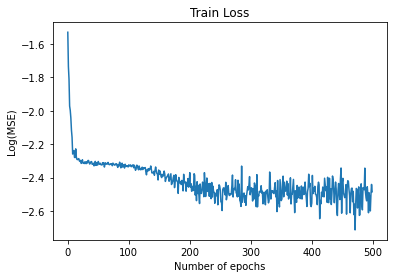

In [29]:
#Plot train loss
ctrain = torch.stack(train_loss_a).detach().cpu().numpy()

plt.title("Train Loss")
plt.plot(np.log(ctrain))
plt.ylabel("Log(MSE)")
plt.xlabel("Number of epochs")

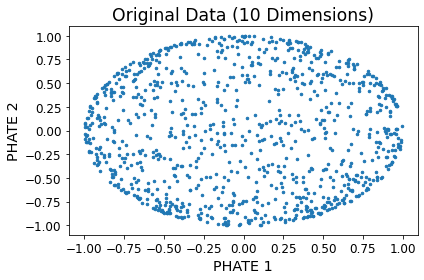

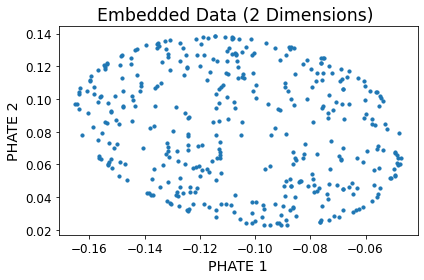

In [30]:
# Get test indices
testind = []
fullind = list(np.arange(X.shape[0]))
for i in fullind:
    if i not in random_indices:
        testind.append(i)

testind = np.array(testind)

# Get samples from autoencoder


nxsample = phate_ae.encoder(X[testind].float().cuda())
xsampout = nxsample.detach().cpu().numpy()




# Visualize ground truth
cax = scprep.plot.scatter2d(
    rotatesphere,
    title="Original Data (10 Dimensions)",
    xlabel="PHATE 1",
    ylabel="PHATE 2",
)


# Visualize Embedding
cax = scprep.plot.scatter2d(xsampout, title="Embedded Data (2 Dimensions) ",xlabel="PHATE 1",ylabel="PHATE 2")


# Compute Jacobian
Jacob = []
for i in testind:
    X_sample = X[i].float().cuda()
    J = torch.autograd.functional.jacobian(phate_ae.encoder, X_sample).squeeze()
    Jacob.append(J.cpu().detach().numpy())

AJacob = np.array(Jacob)
prod = np.empty((X.shape[1],X.shape[1]))


#Compute FIM
FIM = []
for k in range(xsampout.shape[0]):
    prod = np.empty((X.shape[1],X.shape[1]))
    for i in range(AJacob.shape[2]):
        for j in range(AJacob.shape[2]):
            prod[i,j] = np.sum(AJacob[k,:,i] * AJacob[k,:,j] * np.exp(xsampout[k,:]))

    FIM.append(prod)


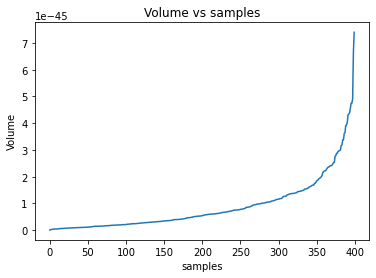

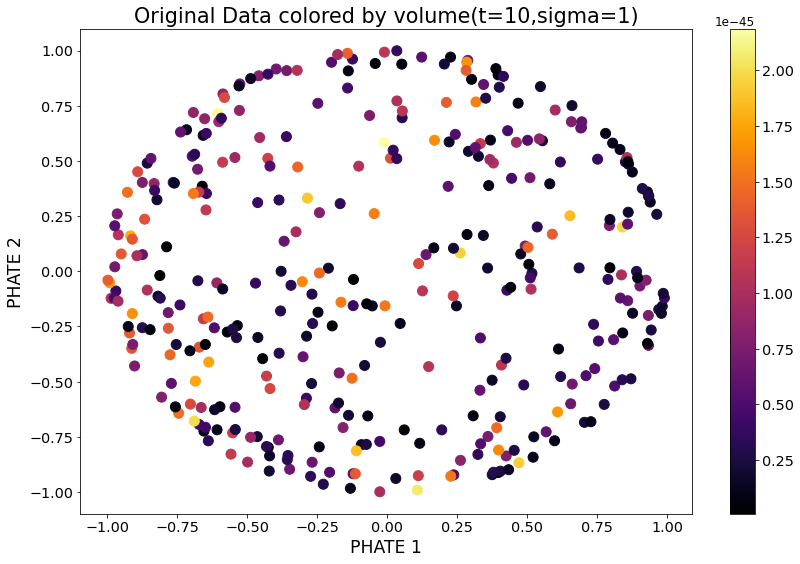

In [31]:
# Analysis/Data Visualization

#Compute Volume
V = np.sqrt(np.abs(np.linalg.det(np.array(FIM))))

#Remove outliers (Take all points within two standard deviations [95%])
Vmedian = np.median(V)
sortind = np.argsort(np.abs(V - Vmedian))[:int(0.90*len(V))]


    

plt.plot(np.sort(V))
plt.title("Volume vs samples")
plt.ylabel("Volume")
plt.xlabel("samples")





# Visualize ground truth
cax = scprep.plot.scatter2d(
    rotatesphere[testind[sortind]],
    c=V[sortind],
    title="Original Data colored by volume(t=10,sigma=1)",
    fontsize=12,
    xlabel="PHATE 1",
    ylabel="PHATE 2",
    figsize = (12,8),
    s = 100
)

V = np.expand_dims(V[sortind],axis=1) #Expand for concatenation
Vsphere = np.concatenate((rotatesphere[testind[sortind]],V),axis=1)
np.save("Vsphere_t_ten_sigone.npy",Vsphere)
